# Analyze sensitivity of population dynamics reporter assay

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import random

## Set output parameters

In [3]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/pop_dyn_sensitivity"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [4]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load preprocessed data.

Preprocessing steps (previously done) consist of:
- Call library barcode.
- Error correction of clone barcode by consensus.
- Sum counts for error corrected clone barcode cluster.
- Call genuine barcodes (filtering to remove errors due to PCR and sequencing noise).

In [5]:
infile = "../preprocessed_data/pop_dyn_sensitivity_data/clone_barcodes.tsv.gz"

obs_raw = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(obs_raw.shape)
obs_raw.head()

(140555, 4)


,lib,library_barcode_call,clone_barcode_consensus,count
0,sFH12-1,LB1,ACAGTCTCACAGTCTGTGAGTGACTCA,25244
1,sFH12-1,LB1,TGACTCACTCTCACAGACTGACTCTGA,13831
2,sFH12-1,LB1,ACTGTCTGAGACACAGTCAGACAGTCA,12507
3,sFH12-1,LB1,TCTGTCTCACACTGTCTCTCTGTCTGT,81
4,sFH12-1,LB1,TGAGACAGAGTGTCTGTCTGAGTCAGT,6


# Preprocess data

## Select data used for this analysis

In [6]:
# Select libraries used in this analysis based on library and library_barcode

libs_keep = ["sFH12-1", "sFH12-2", "sFH12-3", "sFH12-4", "sFH12-5", "sFH12-6", "sFH12-7", "sFH12-8"]

selector = (obs_raw.lib.isin(libs_keep)) & (obs_raw["library_barcode_call"] == "LB2")
obs = obs_raw.loc[selector]

print(obs.shape)
obs.head()

(26353, 4)


,lib,library_barcode_call,clone_barcode_consensus,count
806,sFH12-1,LB2,TCTCAGTCTGTCACACTGTGTCTGTGT,26979
807,sFH12-1,LB2,ACTCTCTGTCAGTCTCTCTCAGACACT,15284
808,sFH12-1,LB2,TCAGTGTGAGTCAGTTAGTTAGAGACA,1873
809,sFH12-1,LB2,AGTCTCAGAGAGTCTCAGTGAGTGTCT,6
810,sFH12-1,LB2,TCAGAGTGACACAGTGTCAGACTCTCT,3


# Define functions for barcode calling 

In [7]:
def find_shoulder_cutoff(counts, N=1000, Q=99, D=10, exclude_top=False):    
    """ Find shoulder of barcode rank plot
    
    Algorithm is adapted from 10X Genomics Cellranger cell barcode identification.
    
    Let N be the expected number of recovered clones.
    Let M be the Qth percentile of the top N barcodes by total read counts, after excluding the top read count. Q is typically 99th percentile.
    Let D be the expected dynamic range of read counts. D is typically 10 - 100.
    
    Then the cutoff count at shoulder is C = M/D.
    
    All barcodes whose total read counts exceed C are called as clones.
    
    Note that we exclude the top read count because it is STD, which always dominates the rest.
    
    Requires N >= 2 (because we drop top read count). If expected number of recovered clones is 1, use N = 2.
    
    """
    if exclude_top:
        C = np.percentile(counts.head(n=N).tail(n=N-1), q=Q) / D
    else:
        C = np.percentile(counts.head(n=N), q=Q) / D
    return C

In [8]:
# Define simple rankplot function

def rankplot_shoulder_pretty(ax, counts, 
                      color, color_background,
                      N_CLONES_EXPECTED=10,
                      Q_TOP_PERCENTILE=99,
                      D_DYNAMIC_RANGE_EXPECTED=20,
                      N_RANK_CUTOFF=10000):
    """ Plot counts versus rank (rank plot).
    Perform barcode calling based on shoulder cutoff.
    Color points that are called as hits in one color and rest of points (background) in another color.
    """

    counts = counts.reset_index(drop=True)

    if counts.shape[0] == 0:
        print("Warning: counts.shape[0] == 0 (empty count list).")

    shoulder_cutoff = find_shoulder_cutoff(counts, N=N_CLONES_EXPECTED, Q=Q_TOP_PERCENTILE, D=D_DYNAMIC_RANGE_EXPECTED)

    counts_subset = counts.head(n=N_RANK_CUTOFF)  # take top N_RANK_CUTOFF
    counts_called = counts_subset[counts_subset > shoulder_cutoff]  # called as clone barcodes
    counts_background = counts_subset[counts_subset < shoulder_cutoff]  # called as background

    counts_background = pd.concat([counts_called.tail(n=1), counts_background])  # concatenate final count of called to make line continuous

    # Plot counts called as clones
    x = counts_called.index+1  # rank
    y = counts_called
    sns.lineplot(ax=ax, x=x, y=y, color=color, zorder=10)
    g = sns.scatterplot(ax=ax, x=x, y=y, marker="o", edgecolor="#ffffff", label=None, color=color, zorder=20)

    # Plot counts called as background
    x = counts_background.index+1  # rank
    y = counts_background
    sns.scatterplot(ax=ax, x=x, y=y, marker=".", edgecolor=None, color=color_background, zorder=1)
    sns.lineplot(ax=ax, x=x, y=y, color=color_background, zorder=1)

    # Add line indicating cutoff
    ax.axhline(shoulder_cutoff, ls="--", lw=1, color="k")
    
    print(len(counts_called), "called")
    
    return g, shoulder_cutoff

# Plot detection of clone barcodes per well

## Set detection and plot parameters

In [9]:
# Set calling parameters
N_CLONES_EXPECTED = 10
Q_TOP_PERCENTILE = 99
D_DYNAMIC_RANGE_EXPECTED = 20

In [10]:
# Set plot parameters

N_RANK_CUTOFF = 100  # maximum rank to show

color = "#d58fbe"
color_background = "#636363"

## Plot barcode abundance in each replicate well

3 called


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


6 called
9 called
4 called
4 called
11 called
5 called
100 called


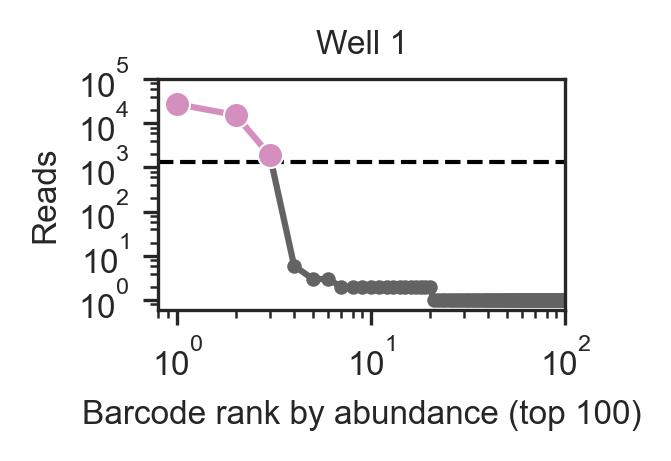

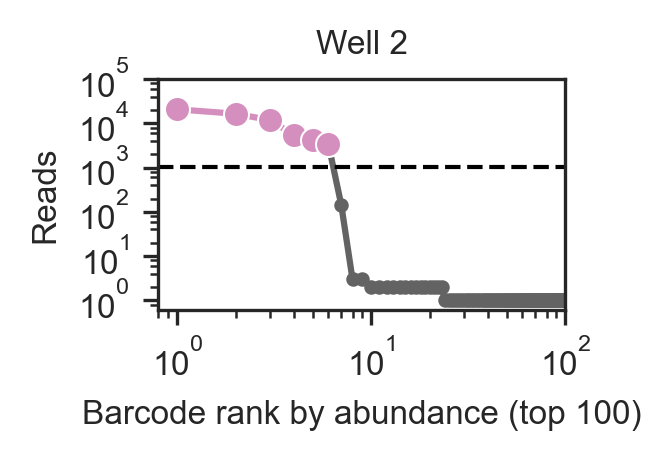

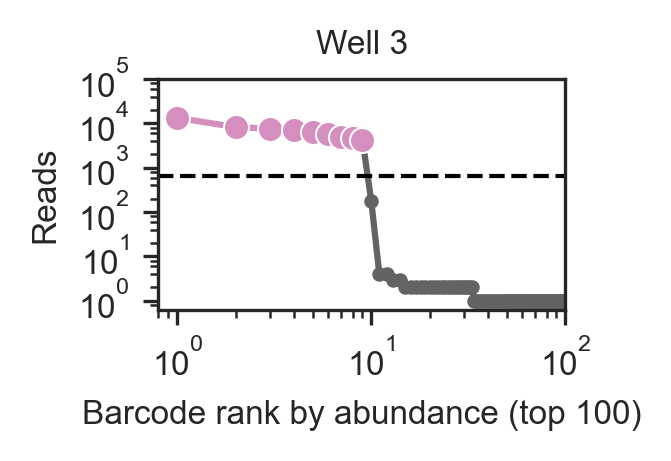

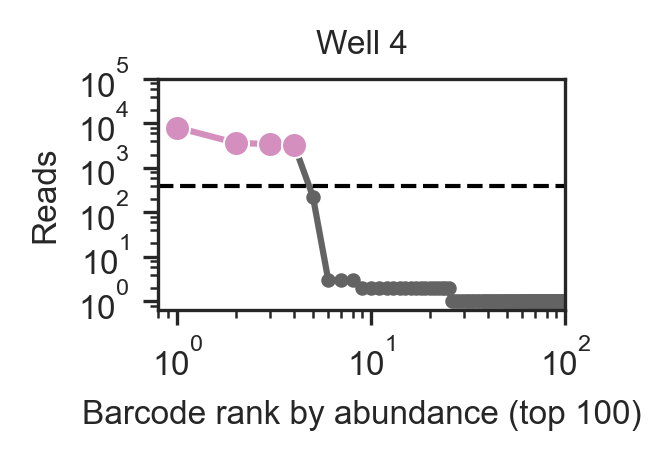

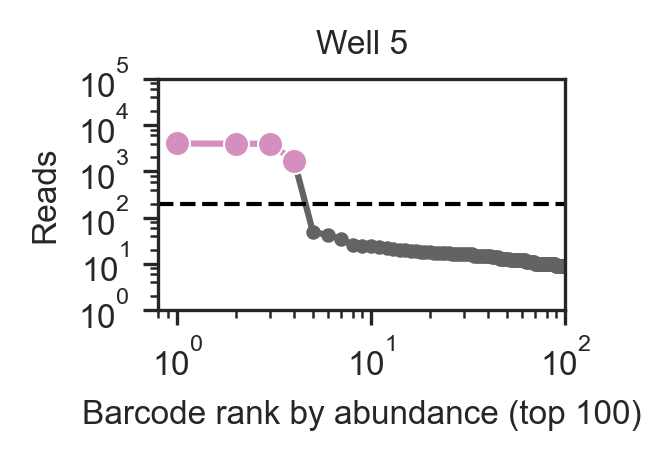

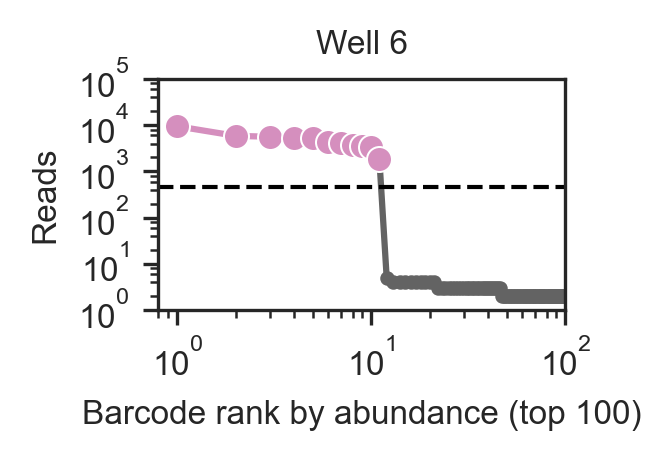

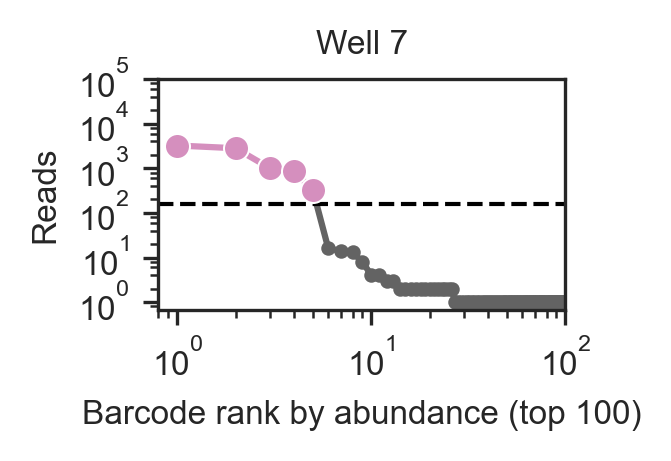

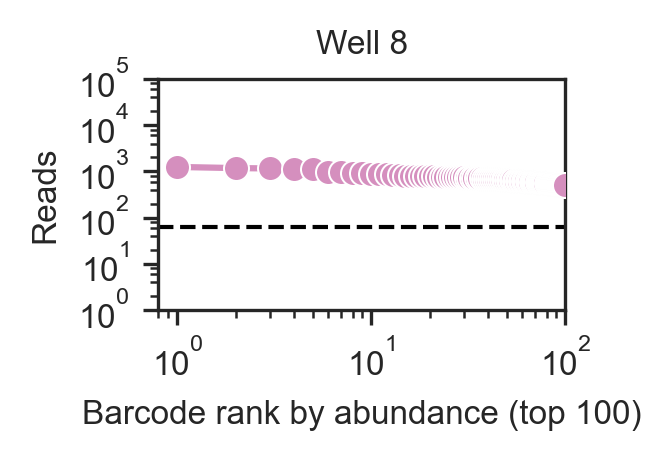

In [11]:
# Libraries correspond to different replicate wells
libs = ["sFH12-1", "sFH12-2", "sFH12-3", "sFH12-4", "sFH12-5", "sFH12-6", "sFH12-7", "sFH12-8"]
wells = [1, 2, 3, 4, 5, 6, 7, 8]  # set well labels

for lib, well in zip(libs, wells):
    
    # Select data
    selector = (obs["lib"] == lib)
    obs_subset = obs.loc[selector]
    counts = obs_subset["count"]  # Get counts per clone

    # Plot calling
    fig, ax = plt.subplots(1, 1, figsize=(1.75,1))

    g = rankplot_shoulder_pretty(ax = ax,
                      counts = counts,
                      color = color,
                      color_background = color_background,
                      N_CLONES_EXPECTED = N_CLONES_EXPECTED,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

    ax.set_xscale("log")
    ax.set_xlim(left=0.8, right=N_RANK_CUTOFF)

    ax.set_yscale("log")
    ax.set_ylim(top=1e5)

    ax.set_xlabel("Barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
    ax.set_ylabel("Reads")
    ax.set_title("Well " + str(well))

    ax.set_yticks([1, 1e1, 1e2, 1e3, 1e4, 1e5])
    locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    save_figure(fig, "rankplot_shoulder_well" + str(well))

## Plot well which lacked shoulder

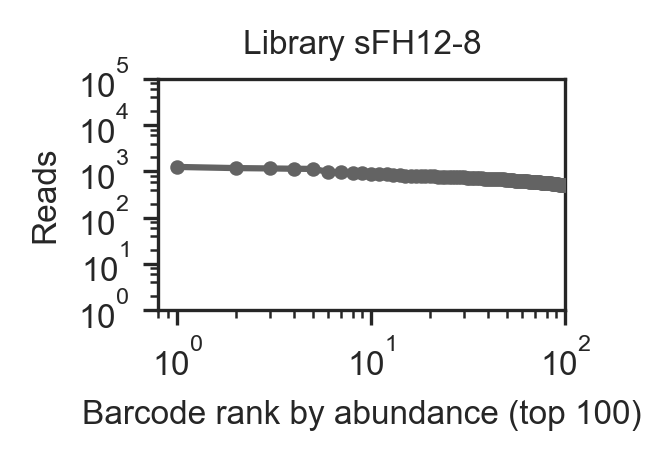

In [12]:
# Plot custom plot for Well 8, which had no shoulder

well = 8
lib = "sFH12-8"

# Select data
selector = (obs["lib"] == lib)
obs_subset = obs.loc[selector]
counts = obs_subset["count"]  # Get counts per clone

# Plot calling
fig, ax = plt.subplots(1, 1, figsize=(1.75,1))

counts = counts.reset_index(drop=True)

if counts.shape[0] == 0:
    print("Warning: counts.shape[0] == 0 (empty count list).")

shoulder_cutoff = find_shoulder_cutoff(counts, N=N_CLONES_EXPECTED, Q=Q_TOP_PERCENTILE, D=D_DYNAMIC_RANGE_EXPECTED)

counts_subset = counts.head(n=N_RANK_CUTOFF)  # take top N_RANK_CUTOFF
counts_called = counts_subset[counts_subset > shoulder_cutoff]  # called as clone barcodes
counts_background = counts_subset[counts_subset < shoulder_cutoff]  # called as background

counts_background = pd.concat([counts_called.tail(n=1), counts_background])  # concatenate final count of called to make line continuous

# Plot counts called as clones
x = counts_called.index+1  # rank
y = counts_called
g = sns.scatterplot(ax=ax, x=x, y=y, marker=".", edgecolor=None, label=None, color=color_background, zorder=20)
sns.lineplot(ax=ax, x=x, y=y, color=color_background, zorder=10)

# Plot counts called as background
x = counts_background.index+1  # rank
y = counts_background
sns.scatterplot(ax=ax, x=x, y=y, marker=".", edgecolor=None, color=color_background, zorder=1)
sns.lineplot(ax=ax, x=x, y=y, color=color_background, zorder=1)

# Add line indicating cutoff
# ax.axhline(shoulder_cutoff, ls="--", lw=1, color="k")

ax.set_xscale("log")
ax.set_xlim(left=0.8, right=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("")

# ax.set_yticklabels([])

ax.set_xlabel("Barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")
ax.set_title("Library " + lib)

ax.set_yticks([1, 1e1, 1e2, 1e3, 1e4, 1e5])
locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

save_figure(fig, "rankplot_shoulder_custom_well" + str(well))

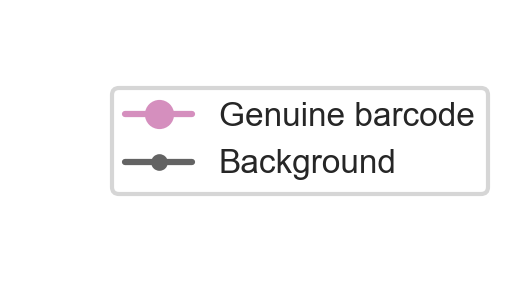

In [13]:
# Plot stand-alone legend

x = [0, 1]
y = x

fig, ax = plt.subplots(1, 1, figsize=(2,1))

ax.plot(x, y, "-", marker="o", color=color, label="Genuine barcode")
ax.plot(x, y, "-", marker=".", color=color_background, label="Background")

ax.axis('off')
ax.set_xlim(2,3)

fig.legend(loc="center", bbox_to_anchor=(0.5, 0.5))

save_figure(fig, "legend_shoulder_call")

In [14]:
# Report cells detected
# Manually compiled counts from printed text above
x = [3, 6, 9, 4, 4, 11, 5, 0]  # counts

print("Mean", np.mean(x))
print("STD", np.std(x))

Mean 5.25
STD 3.2307119958300214


# Plot saturation of clone discovery with respect to sequencing depth (rarefaction analysis)

## Perform rarefaction (subsample reads and detect clones)

In [15]:
# Set sampling parameters 
n_reads = [1e1, 2e1, 5e1,
           1e2, 2e2, 5e2,
           1e3, 2e3, 5e3,
           1e4, 2e4, 5e4,
           1e5, 2e5]  # reads to sample
n_replicates = 10  # number of replicates

# Specify libraries
libs = ["sFH12-1", "sFH12-2", "sFH12-3", "sFH12-4", "sFH12-5", "sFH12-6", "sFH12-7"]

# Specify well labels
wells = [1, 2, 3, 4, 5, 6, 7]

In [16]:
%%time

wells_as_list = []
n_reads_as_list = []
n_replicates_as_list = []
n_clones_detected_as_list = []
shoulder_cutoff_estimated_as_list = []
shoulder_cutoff_as_list = []

for lib, well in zip(libs, wells):
    
    # Get read counts for well
    selector = (obs["lib"] == lib)
    obs_subset = obs.loc[selector]
    counts = obs_subset["count"]  # Get counts per clone
    
    for _n_reads in n_reads:
        
        if _n_reads > sum(counts):
            # Set maximum number of sampled reads to the total number of reads
            _n_reads = sum(counts)
        
        # Set random seed for reproducible results
        random.seed(0)
        
        for replicate_i in range(n_replicates):
            
            # Sample reads
            counts_sampled = pd.Series(random.choices(list(counts.index), weights=counts, k=int(_n_reads))).value_counts().head(n=20)
            
            # Call barcodes
            shoulder_cutoff_estimated = find_shoulder_cutoff(counts_sampled, N=N_CLONES_EXPECTED, Q=Q_TOP_PERCENTILE, D=D_DYNAMIC_RANGE_EXPECTED)
            
            if shoulder_cutoff_estimated < 10:
                shoulder_cutoff = 10
            else:
                shoulder_cutoff = shoulder_cutoff_estimated

            # Clones detected
            n_clones_detected = sum(counts_sampled > shoulder_cutoff)
            
            # Append to results
            wells_as_list.append(well)
            n_reads_as_list.append(_n_reads)
            n_replicates_as_list.append(replicate_i)
            n_clones_detected_as_list.append(n_clones_detected)
            shoulder_cutoff_estimated_as_list.append(shoulder_cutoff_estimated)
            shoulder_cutoff_as_list.append(shoulder_cutoff)

# Create dataframe
data = {"well": wells_as_list,
        "n_reads": n_reads_as_list,
        "n_replicate": n_replicates_as_list,
        "n_clones_detected": n_clones_detected_as_list,
        "shoulder_cutoff_estimated": shoulder_cutoff_estimated_as_list,
        "shoulder_cutoff": shoulder_cutoff_as_list}

obs_sampled = pd.DataFrame(data)

print(obs_sampled.shape)
obs_sampled.head()

(980, 6)
CPU times: user 11 s, sys: 1.59 ms, total: 11 s
Wall time: 11 s


,well,n_reads,n_replicate,n_clones_detected,shoulder_cutoff_estimated,shoulder_cutoff
0,1,10.0,0,0,0.348,10.0
1,1,10.0,1,0,0.297,10.0
2,1,10.0,2,0,0.249,10.0
3,1,10.0,3,0,0.250,10.0
4,1,10.0,4,0,0.345,10.0


## Plot rarefaction curve

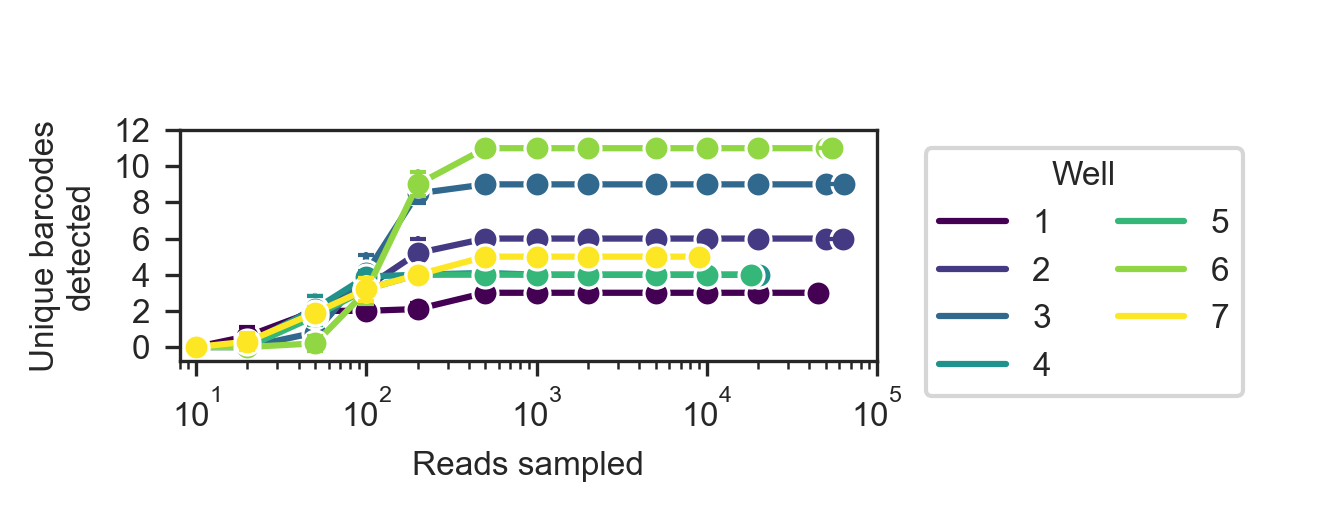

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3,1))

sns.lineplot(ax=ax,
             data=obs_sampled,
             x="n_reads",
             y="n_clones_detected",
             hue="well",
             palette="viridis",
             marker="o",
             # alpha=0.5,
             errorbar="sd",
             err_style="bars",
             err_kws={"capsize": 2,
                      "capthick": 1}
            )

ax.set_xscale("log")
ax.set_xlim(8, 1e5)

ax.set_xlabel("Reads sampled")
ax.set_ylabel("Unique barcodes\ndetected")

ax.set_yticks([0, 2, 4, 6, 8, 10, 12])

ax.get_legend().remove()  # remove existing legend
fig.legend(loc="center left", bbox_to_anchor=(1.01,0.8), title="Well", ncol=2)

save_figure(fig, "saturation_curve")